# Ugly Duckings Logistic Model (Worse Metrics)

## Import required packages

In [263]:
## Data, maths and visualisations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models and metrics
from sklearn.linear_model import LogisticRegression # is the package to build the linear regression model
from sklearn import metrics # contains functions for module evaluation
from sklearn.utils.class_weight import compute_class_weight

# train/test split lib and feature selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

# Smote
from imblearn.over_sampling import SMOTE

# To transform string to list
import ast

## Load Data

In [266]:
pd.options.display.max_columns = None ## Dont limit number of columns displayed

In [268]:
df = pd.read_csv("swan_data.csv") ## Load in data

## Cleaning and Feature Engineering Functions

In [271]:
def data_cleaning(df):
    #Making a copy of the dataset
    df = df.copy()

    #Using CustomerID as index
    df.set_index("CustomerID", inplace=True)

    #Fixing Total Charges column - inserting zeroes for blank columns and casting to float
    df["Total Charges"] = df["Total Charges"].str.replace(" ", "0")
    df = df.astype({"Total Charges": float})

    #Dropping unnecessary columns
    df.drop(columns=["Count", "Country", "State", "City", "Zip Code", "Lat Long", "Churn Label", "Churn Reason"], inplace=True)

    #Mapping columns to numeric values
    #General case, where values are "yes" and "no". Results like "no phone service" are mapped to 0 since the lack of phone service is contained in a different column
    general_mapper = {"No":0, "Yes":1, "No phone service": 0, "No internet service": 0}
    for col in df.columns:
        if "No" in df[col].unique() and "Yes" in df[col].unique():
            df[col] = df[col].map(general_mapper)
    
    #Mapping male to 0 and female to 1
    gender_mapper = {"Male":0, "Female":1}
    df["Gender"] = df["Gender"].map(gender_mapper)

    #Mapping contract lengths into a value representing the length of the contract term in years
    contract_mapper = {"Month-to-month": 1/12, "Two year": 2, "One year":1}
    df["Contract"] = df["Contract"].map(contract_mapper)

    return df


In [273]:
## Function to get descrete metrics
def metrics_func(actual, pred):
    accuracy = metrics.accuracy_score(actual, pred)
    precision = metrics.precision_score(actual, pred)
    recall = metrics.recall_score(actual, pred)
    f1 = metrics.f1_score(actual, pred)

    print(f'accuracy: {accuracy*100}%')
    print(f'precision: {precision*100}%')
    print(f'recall: {recall*100}%')
    print(f'f1: {f1*100}%')

In [275]:
# Returns the metrixs for model with threshold = n
def cutoff_change(target, data, n):
    data['y_pred'] = np.where(data.prob_churn > n, # Threshold
                                   1, # Condition if met
                                   0) # Condition if not met
    return metrics_func(target, data['y_pred'])

In [277]:
## One hot encoding of necessary features and removal of columns.
def feature_engineering(df): 
    # OHE Payment Method and Internet Service columns
    df = pd.get_dummies(df, 
                        columns = ['Payment Method', 'Internet Service'], 
                        prefix = ['pay','is'], 
                        drop_first = True, 
                        dtype = int)
    
    
    return df.drop(columns = ['Partner', 'Paperless Billing'])

## Logistic Regression Model

In [280]:
df_clean = data_cleaning(df) # Apply data cleaning

In [282]:
# Split features and target
X = df_clean.drop(columns = 'Churn Value').copy()
y = df_clean['Churn Value'].copy()

## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, # features
                                                    y, # target
                                                    test_size=0.2, # What proportion of data is for testing
                                                    random_state=1204) ## Seed for random split

In [284]:
X_train_fe = feature_engineering(X_train) # Apply feature engineering

In [286]:
all(X_train_fe.index == y_train.index) # sanity check

True

### Initial model

In [289]:
## Initial model for feature selection
first_logreg = LogisticRegression(max_iter=10000, 
                                    penalty='l1', 
                                    solver='liblinear')

In [291]:
first_logreg.fit(X_train_fe, y_train)

LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')

### Feature selection

In [294]:
# Initialising selected model
selection = SelectFromModel(first_logreg, # initial model
                            prefit=True, # Has first_logreg already been fit
                            importance_getter='coef_',
                            threshold='median') # Determines selection of features based on coefficients

# New X_train with only selected features
X_train_sel = selection.fit_transform(X_train_fe)

# Retrieve columns that the model found most important
feature_cols = selection.get_support()
feature_name = X_train_fe.columns[feature_cols]

# New df with only selected features
X_train_sel = pd.DataFrame(X_train_sel, columns = feature_name)

In [296]:
X_train_sel.head() ## Check of what features were kept

,Dependents,Phone Service,Multiple Lines,Online Security,Online Backup,Tech Support,Streaming Movies,Contract,pay_Electronic check,is_Fiber optic,is_No
0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.083333,0.0,1.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.083333,1.0,1.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.083333,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,1.0,1.0,0.0


### Class imbalance

In [299]:
# Define the SMOTE model
smote = SMOTE()

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_sel, y_train)

In [301]:
y_train_smote.value_counts()

Churn Value
0    4141
1    4141
Name: count, dtype: int64

### Optimise recall

In [304]:
log_reg = LogisticRegression(penalty = 'l1', solver='liblinear') ## New model to apply to resampled and featured selected data

In [306]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # λ = 1/C and λ is penalty weight applied to coefficients
    'max_iter': [500,1000,5000,10000] # maximum iterations of model
}

# Implement GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring='recall') ## Set to maximise recall
grid_search.fit(X_train_smote, y_train_smote) ## Applied to the resampled data. Only training set is resampled.

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [500, 1000, 5000, 10000]},
             scoring='recall')

In [307]:
best_recall = grid_search.best_estimator_ ## Final model

### Model in use

In [309]:
X_train_smote[['prob_retain','prob_churn']] = best_recall.predict_proba(X_train_smote) # Predictions with final model

In [310]:
cutoff_change(y_train_smote, X_train_smote, 0.5) #Find metrics with threshold = 0.5

accuracy: 76.99830958705627%
precision: 74.58223394898856%
recall: 81.91258150205265%
f1: 78.07572793186787%


In [311]:
X_test_fe = feature_engineering(X_test) # Apply feature engineering
X_test_sel = selection.transform(X_test_fe)
X_test_sel = pd.DataFrame(X_test_sel, columns=feature_name) ## X_test with selected features

X_test_sel[['prob_retain','prob_churn']] = best_recall.predict_proba(X_test_sel) # Test predictions with final model

cutoff_change(y_test, X_test_sel, 0.5) #Find metrics with threshold = 0.5

accuracy: 73.81121362668559%
precision: 50.58043117744611%
recall: 81.11702127659575%
f1: 62.30847803881512%


In [312]:
cm = metrics.confusion_matrix(y_test,X_test_sel['y_pred']) # Confusion matrix of test results

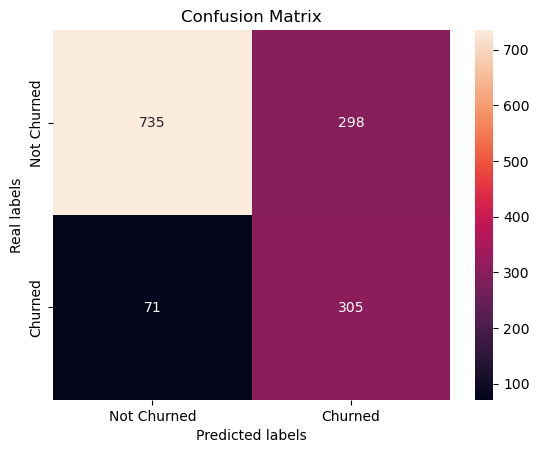

In [313]:
## plot heatmap for confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

# axis labels and axis titles and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])

plt.show()

## List Creation

### 500 Most likely to churn

In [248]:
## Transform whole data
X_fe = feature_engineering(X)
X_sel = selection.transform(X_fe)
X_sel = pd.DataFrame(X_sel, columns=feature_name)

X_sel = X_sel.set_index(y.index)

In [319]:
# Make predictions
X_sel[['prob_retain','prob_churn']] = best_accuracy.predict_proba(X_sel)
X_sel['Churn Value'] = y
X_sel.reset_index(inplace = True)

In [323]:
## Top 500 probabilites of churning from all the customers where churn value = 0
risk_500 = X_sel[X_sel['Churn Value'] == 0][['CustomerID','prob_churn']]\
    .sort_values(by = 'prob_churn',
                 ascending = False)[:500]

In [ ]:
risk_500 = risk_500.drop(columns = 'prob_churn') # Leave only top 500 customers

In [370]:
# Convert to csv
risk_500.to_csv("Logistic_500.csv", index=False)

### Churn risk

In [357]:
# All probabilies of churning for customers with churn value = 0
churn_risk = X_sel[X_sel['Churn Value'] == 0][['CustomerID','prob_churn']]\
    .sort_values(by = 'prob_churn',
                 ascending = False)

In [366]:
# Convert to csv
churn_risk.to_csv("Churn Risk.csv", index=False)